# Using lecture baseline as my baseline

In [1]:
!pip install neptune > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.34.64 which is incompatible.


In [2]:
import glob
import pandas as pd
import neptune
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from torchvision.transforms.v2 import *
from PIL import Image
import timm
import random

from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from transformers import get_cosine_schedule_with_warmup
from tqdm import tqdm
from torch import autocast, nn, sigmoid, softmax
from torch.distributions.beta import Beta
from torch.distributions.uniform import Uniform

train_df = pd.read_csv("/kaggle/input/nie-pdl23-final-competition/train.csv")
test_df = pd.read_csv("/kaggle/input/nie-pdl23-final-competition/test.csv")

lbl_map = {lbl:i for i, lbl in enumerate(sorted(set(train_df["label"])))}
print(lbl_map)

train_df["image"] = "/kaggle/input/nie-pdl23-final-competition/images/"+ train_df["image_id"]
train_df["fold"] = train_df.index%5
test_df["image"] = "/kaggle/input/nie-pdl23-final-competition/images/"+ test_df["image_id"]

train_df.head()

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

{'Andy-Warhol': 0, 'Claude-Monet': 1, 'Pablo-Picasso': 2, 'Rembrandt-Harmenszoon-van-Rijn': 3, 'Salvador-Dali': 4, 'Vincent-van-Gogh': 5}


,image_id,label,image,fold
0,2344.png,Claude-Monet,/kaggle/input/nie-pdl23-final-competition/imag...,0
1,6366.png,Salvador-Dali,/kaggle/input/nie-pdl23-final-competition/imag...,1
2,5133.png,Rembrandt-Harmenszoon-van-Rijn,/kaggle/input/nie-pdl23-final-competition/imag...,2
3,3685.png,Salvador-Dali,/kaggle/input/nie-pdl23-final-competition/imag...,3
4,6938.png,Claude-Monet,/kaggle/input/nie-pdl23-final-competition/imag...,4


In [3]:
imageNetMean = [0.485, 0.456, 0.406]
imageNetStd = [0.229, 0.224, 0.225]

# Define the Dataset class
class CustomDataset(Dataset):
    def __init__(self,  df, image_col, label_col, resolution, mode):
        self.images = df[image_col].tolist()
        self.labels = None if label_col not in df.columns else df[label_col].values.tolist()
        self.resolution = resolution
        
        if mode == "train":
            self.aug =  Compose([
                Resize((resolution, resolution)),
                RandomHorizontalFlip(p=0.5),
                ToImageTensor(),
                ConvertImageDtype(),
                Normalize(mean=imageNetMean, std=imageNetStd)
            ])
        else:
            self.aug =  Compose([
                Resize((resolution, resolution)),
                PILToTensor(),
                ToImageTensor(),
                ConvertImageDtype(),
                Normalize(mean=imageNetMean, std=imageNetStd)
            ])
            

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = Image.open(self.images[idx])
        x = self.aug(x)
        res = {"input": x}
        if self.labels is not None:
            res["target"] = torch.tensor(lbl_map[self.labels[idx]]).long()
            
        return res

In [4]:
def cutmix(images, labels, alpha=1.0):
    bs, c, w, h = images.shape
    idxs = torch.randperm(bs)
    # Generate lambda and indexes
    lam = Beta(alpha, alpha).sample()
    r_x = Uniform(0, w).sample().int()
    r_y = Uniform(0, h).sample().int()
    lam_ratio = torch.sqrt(1. - lam)
    r_w = (w * lam_ratio).int()
    r_h = (h * lam_ratio).int()
    # Calculate bounding box
    x1 = torch.clamp(r_x - r_w // 2, min=0)
    x2 = torch.clamp(r_x + r_w // 2, max=w)
    y1 = torch.clamp(r_y - r_h // 2, min=0)
    y2 = torch.clamp(r_y + r_h // 2, max=h)
    # Apply based on permutation
    images[:, :, x1:x2, y1:y2] = images[idxs, :, x1:x2, y1:y2]
    # Update labels
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=6)
    label_ratio = 1 - (x2-x1)*(y2-y1) / (w * h)
    labels = labels_one_hot * label_ratio + labels_one_hot[idxs] * (1 - label_ratio)
    
    return images, labels

In [5]:
# import matplotlib.pyplot as plt
# N=4

# batch = next(iter(train_dl))
# imgs, labels = cutmix(batch['input'], batch['target'])

# plt.figure(figsize=(10,10))
# for i in range(N):
#     plt.subplot( 4, 1, i+1)
    
#     img = imgs[i]
#     title = labels[i]
#     img = img.permute(1,2,0)
#     img *= np.array([0.229, 0.224, 0.225])
#     img += np.array([0.485, 0.456, 0.406])
#     plt.imshow(img)
#     plt.title(title)

# plt.tight_layout()

In [6]:
# Code for GeM from: https://amaarora.github.io/posts/2020-08-30-gempool.html
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    
    # apply avg pool to x^p for the inputs, the kernel size is the size of the feature map
    # so it is basically AdaptiveAvgPool(1), we clamp values to be at least eps and
    # the pooling output is raised to the power of p as in the lecture
    # p is a trainable parameter
    def gem(self, x, p=3, eps=1e-6):
        return nn.functional.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
#         x = x.clamp(min=eps).pow(p)
#         return nn.functional.adaptive_avg_pool2d(x, 1).pow(1./p)

class Head(nn.Module):
    def __init__(self, layers, activation=nn.ReLU):
        super().__init__()
        my_layers = []
        
        for i in range(len(layers)-1):
            my_layers.append(nn.Linear(layers[i], layers[i+1]))
            if i< len(layers)-2:
                my_layers.append(activation())

        self.layers = nn.ModuleList(my_layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class CustomModel(nn.Module):
    def __init__(self, backbone, num_outputs, hidden_layers=None, tim_head=False, dropout_p=0):
        super().__init__()
        
        self.backbone_name = backbone
        self.tim_head = tim_head
        
        args = dict(
            model_name=self.backbone_name,
            pretrained=True,
            drop_rate=0,
            in_chans=3,
        )
        if not tim_head:
            args = {"global_pool": "", "num_classes": 0, **args}
        else:
            args = {"num_classes": num_outputs, **args}
            
        self.backbone = timm.create_model(**args)
        
#         self.pool = nn.AdaptiveAvgPool2d(1)
        self.pool = GeM()
        self.dropout = nn.Dropout(dropout_p)
        self.num_outputs = num_outputs

        hidden_layers = hidden_layers if hidden_layers else []
        hidden_layers = [self.backbone.num_features] + hidden_layers + [num_outputs]
        self.head = Head(hidden_layers)
    
    def forward(self, x, print_shapes=False, apply_softmax=False):
        x = self.backbone(x)
        
        if print_shapes:
            print("Backbone output shape", x.shape)
        
        if not self.tim_head:
            # Problem between pooling output and head with swinv2 model
            if self.backbone_name.startswith("swinv2"):
                x = x.permute(0,3,1,2)
            
            x = self.pool(x)
            
            if print_shapes:
                print("Pool output shape", x.shape)
            
            x = self.dropout(x)
            
            x = x[:, :, 0 , 0]
            if print_shapes:
                print("Pool output flattened", x.shape)

            x = self.head(x)
            if print_shapes:
                print("Head output shape", x.shape)
            
        if apply_softmax:
            x = softmax(x, 1)
            
        # reduce single dimension
        if self.num_outputs == 1:
            x = x.view(-1)
            
        return x




## Training loop

In [7]:
def accuracy(x, y):
    return accuracy_score(x, np.array(y).argmax(axis=1))


def train_loop(train_dl, model, loss_fn, optimizer, scheduler, device, scaler, cutmix_p=0, log_every=1):
    losses = []
    lr_values = []
    size = len(train_dl)
    
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
     
    pbar = tqdm(train_dl)
    for batch_idx, batch_dict in enumerate(pbar):
        if random.random() < cutmix_p:
            batch_dict["input"], batch_dict["target"] = cutmix(batch_dict["input"], batch_dict["target"])  
        else:
            batch_dict["target"] = batch_dict["target"].long()
        
        x = batch_dict["input"]
        x = x.to(device)  
        y = batch_dict["target"].to(device)
        
        with autocast(device_type='cuda', dtype=torch.float16):
            # Compute prediction and loss
            pred = model(x)
            loss = loss_fn(pred, y)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()
        optimizer.zero_grad()
        
        if batch_idx % log_every == 0:
            losses.append(loss.detach().cpu().item())
            lr_values.append(scheduler.get_lr()[0])
        
        loss, current = loss.item(), (batch_idx + 1)
        pbar.set_description(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return losses, lr_values


def inference_loop(model, dataloader, device, tta=False, **predict_kwargs):
    model.to(device)
    predictions = []
    labels = []
    
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    model.eval()
    
    with torch.no_grad():
        for batch_dict in tqdm(dataloader):
            x = batch_dict["input"]
            x = x.to(device)
            y = batch_dict.get("target")
            
            with autocast(device_type='cuda', dtype=torch.float16):
                pred = model(x, **predict_kwargs)
                #manual test time augmentation - hflip and mean
                if tta:
                    # Flip the image horizontally
                    x_flip = torch.flip(x, dims=[3])
                    pred_flip = model(x_flip, **predict_kwargs)
                    # Calculate mean
                    pred = torch.mean(torch.stack([pred, pred_flip]), dim=0)
            # we move predictions to cpu, in case they are stored on GPU
            predictions.extend(pred.cpu().tolist())
            
            if y is not None:
                labels.extend(y.cpu().tolist())
                
    return predictions, labels


def validation_loop(val_dl, model, val_metrics, device, tta=False):
    predictions, labels = inference_loop(model, val_dl, device, tta=tta, apply_softmax=True)
    scores = {metric.__name__: metric(labels, predictions) for metric in val_metrics}
    return scores


def predict(model, test_dl, device, apply_softmax=True, tta=False):
    model.to(device)
    predictions, _ = inference_loop(model, test_dl, device, tta=tta, apply_softmax=apply_softmax)
    return predictions


def train(model, train_dl, val_dl, loss, optimizer, scheduler, epochs, val_metrics, device, scaler,
          neptune, cutmix_p=0, val_skip=False, tta=False):
    scores = []
    losses = []
    lr_rates = []
    
    model.to(device)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}\n-------------------------------")
        epoch_losses, epoch_lr_rates = train_loop(train_dl, model, loss, optimizer, scheduler, device, scaler, cutmix_p)
        #Validation might be skipped
        if not val_skip:
            epoch_scores = validation_loop(val_dl, model, val_metrics, device, tta)
            print(epoch_scores)
            scores.append(epoch_scores)
            neptune["train/scores"].append(epoch_scores)
        losses.extend(epoch_losses)
        lr_rates.extend(epoch_lr_rates)
        neptune["train/losses"].extend(epoch_losses)
        neptune["train/lr_rates"].extend(epoch_lr_rates)
    print("Done!")
    return model, scores, losses, lr_rates

In [8]:
# backbone = "tf_efficientnetv2_m.in21k"
# backbone = "tf_efficientnetv2_b3.in1k"
# backbone = "tf_efficientnetv2_m.in21k_ft_in1k"
# backbone = "swinv2_tiny_window16_256.ms_in1k"
# backbone = "tf_efficientnetv2_s.in21k"

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/k4ktus/PDL-cv-competition/e/PDLCVCOM-41


[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 1/5
-------------------------------


  0%|          | 0/405 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
loss: 0.918269  [  405/  405]: 100%|██████████| 405/405 [10:02<00:00,  1.49s/it]


Epoch 2/5
-------------------------------


loss: 1.360596  [  405/  405]: 100%|██████████| 405/405 [09:09<00:00,  1.36s/it]


Epoch 3/5
-------------------------------


loss: 1.485840  [  405/  405]: 100%|██████████| 405/405 [09:09<00:00,  1.36s/it]


Epoch 4/5
-------------------------------


loss: 0.002600  [  405/  405]: 100%|██████████| 405/405 [09:08<00:00,  1.36s/it]


Epoch 5/5
-------------------------------


loss: 0.002914  [  405/  405]: 100%|██████████| 405/405 [09:08<00:00,  1.35s/it]

Done!
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 10 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 10 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/k4ktus/PDL-cv-competition/e/PDLCVCOM-41/metadata


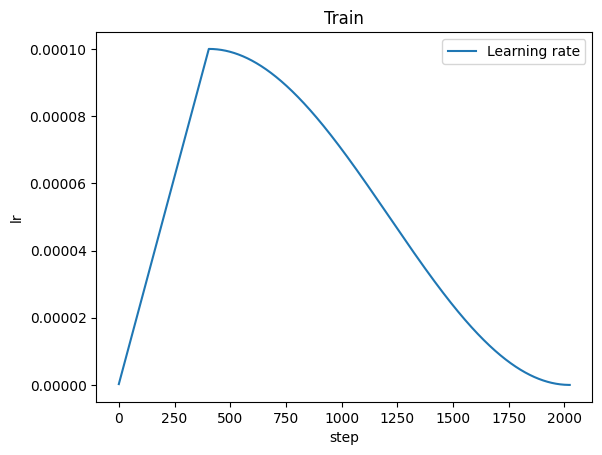

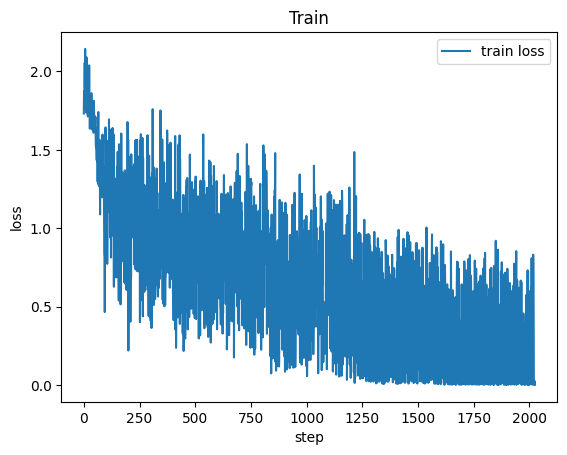

In [9]:
# Specify all hyper-parameters
# backbone = "swinv2_base_window16_256.ms_in1k"
backbone = "swinv2_large_window12to16_192to256.ms_in22k_ft_in1k"
num_classes = 6
hidden_layers = None
tim_head = False
dropout_p = 0.2
image_size = 256

device = "cuda"
learning_rate = 1e-4
batch_size = 16
epochs = 5
warmup_epochs = 1

sample_size = None
val_skip = True
full_data = True
cutmix_p = 0.5
tta_flip = True

#Setup neptune logging
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
run = neptune.init_run(
    project=user_secrets.get_secret("neptune_cv_project"),
    api_token=user_secrets.get_secret("neptune_api_token")
)

params = {
    "backbone": backbone,
    "n_classes": num_classes,
    "tim_head": tim_head,
    "dropout_p": dropout_p,
    "pool": "GeM",
    "image_size": image_size,  
    "lr": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs,
    "warmup_epochs": warmup_epochs,
    "train_test_split": 1,
    "train_img_aug": ["hlfip0.5"],
    "train_batch_aug": [f"cutmix{cutmix_p}"],
    "inference_aug": []
}
run["parameters"] = params

val_metrics = [accuracy, log_loss]
loss = nn.CrossEntropyLoss()
model = CustomModel(backbone, num_classes, hidden_layers, tim_head=tim_head)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Creates a GradScaler once at the beginning of training.
scaler = torch.cuda.amp.GradScaler()

act_train = train_df
act_val = train_df.query("fold==0")
if not full_data:
    act_train = train_df.query("fold!=0")
    act_val = train_df.query("fold==0")

if sample_size:
    act_train = act_train.head(sample_size)
    act_val = act_val.head(sample_size)

# Get datasets and data loaders
train_ds = CustomDataset(act_train, "image", "label", image_size, "train")
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = CustomDataset(act_val, "image", "label", image_size, "test")
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Get scheduler
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_epochs * len(train_dl), num_training_steps=epochs * len(train_dl)
)

# Train model
model, val_scores, train_losses, lr_rates = train(
    model, train_dl, val_dl, loss, optimizer, scheduler, epochs, val_metrics, device, scaler,
    neptune=run, cutmix_p=cutmix_p, val_skip=val_skip, tta=tta_flip
)

run.stop()

# Save model weights
# torch.save(model.state_dict(), 'model_weights.pth')

# Plot Learning Rates
pd.DataFrame({"Learning rate":lr_rates}).plot(xlabel="step", ylabel="lr", style="-", title="Train")

# Plot Train Losses
pd.DataFrame({"train loss":train_losses}).plot(xlabel="step", ylabel="loss", style="-", title="Train")

if not val_skip:
    # Plot Validation Metrics
    pd.DataFrame(val_scores).plot(xlabel="epoch", ylabel="score", style="o-", title="Validation")

    # Show validation metrics
    val_scores_df = pd.DataFrame(val_scores)
    val_scores_df.index.name = "epoch"
    val_scores_df

## Submission

We create the submission file along with the file containing raw probabilities. The file with predicted probabilities can be used to ensemble multiple pipelines.

In [10]:
inverse_lbl_map = {v:k for k,v in lbl_map.items()}
# Get test dataset and data loader
test_ds = CustomDataset(test_df, "image", "label", image_size, "test")
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Set model to inference mode
model.eval()

# Predict on test data
preds = predict(model, test_dl, "cuda", tta=tta_flip)
preds = np.array(preds)

sub = test_df[["image_id"]].copy()
sub["label"] = preds.argmax(axis=1)

sub["label"] = sub["label"].map(inverse_lbl_map)

path = f"swin_sub_full.csv"
print(path)
sub.to_csv(path, index=False)

path = f"swin_proba_full.csv"
print(path)
proba = pd.DataFrame(preds, columns = lbl_map.keys())
proba = pd.concat([test_df[["image_id"]],proba], axis=1)
proba.to_csv(path, index=False)

display(proba.head())
sub.head()

100%|██████████| 125/125 [02:22<00:00,  1.14s/it]

swin_sub_full.csv
swin_proba_full.csv


,image_id,Andy-Warhol,Claude-Monet,Pablo-Picasso,Rembrandt-Harmenszoon-van-Rijn,Salvador-Dali,Vincent-van-Gogh
0,6188.png,0.000092,0.000275,0.000163,0.998892,0.000508,0.000070
1,4895.png,0.000257,0.000448,0.996040,0.000932,0.000523,0.001801
2,7716.png,0.000151,0.002605,0.000173,0.000150,0.000206,0.996715
3,4180.png,0.000309,0.998657,0.000168,0.000333,0.000305,0.000229
4,5261.png,0.999281,0.000207,0.000092,0.000164,0.000154,0.000102


,image_id,label
0,6188.png,Rembrandt-Harmenszoon-van-Rijn
1,4895.png,Pablo-Picasso
2,7716.png,Vincent-van-Gogh
3,4180.png,Claude-Monet
4,5261.png,Andy-Warhol


## Timm model selection

In [11]:
model_list = timm.list_models(pretrained=True)
efNet_list = [m for m in model_list if "efficientnetv2" in m.lower()]
swin_list = [m for m in model_list if "swinv2" in m.lower()]

for l in efNet_list:
    print(l)
print("========================")
for l in swin_list:
    print(l)

efficientnetv2_rw_m.agc_in1k
efficientnetv2_rw_s.ra2_in1k
efficientnetv2_rw_t.ra2_in1k
gc_efficientnetv2_rw_t.agc_in1k
tf_efficientnetv2_b0.in1k
tf_efficientnetv2_b1.in1k
tf_efficientnetv2_b2.in1k
tf_efficientnetv2_b3.in1k
tf_efficientnetv2_b3.in21k
tf_efficientnetv2_b3.in21k_ft_in1k
tf_efficientnetv2_l.in1k
tf_efficientnetv2_l.in21k
tf_efficientnetv2_l.in21k_ft_in1k
tf_efficientnetv2_m.in1k
tf_efficientnetv2_m.in21k
tf_efficientnetv2_m.in21k_ft_in1k
tf_efficientnetv2_s.in1k
tf_efficientnetv2_s.in21k
tf_efficientnetv2_s.in21k_ft_in1k
tf_efficientnetv2_xl.in21k
tf_efficientnetv2_xl.in21k_ft_in1k
swinv2_base_window8_256.ms_in1k
swinv2_base_window12_192.ms_in22k
swinv2_base_window12to16_192to256.ms_in22k_ft_in1k
swinv2_base_window12to24_192to384.ms_in22k_ft_in1k
swinv2_base_window16_256.ms_in1k
swinv2_cr_small_224.sw_in1k
swinv2_cr_small_ns_224.sw_in1k
swinv2_cr_tiny_ns_224.sw_in1k
swinv2_large_window12_192.ms_in22k
swinv2_large_window12to16_192to256.ms_in22k_ft_in1k
swinv2_large_window12